In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Using TensorFlow backend.


load data

In [ ]:
from load_data import *

X_data, y_data = load_data()

loading spin 000 90 incl images....
loading spin 001 90 incl images....
loading spin 002 90 incl images....
loading spin 003 90 incl images....
loading spin 004 90 incl images....
loading spin 005 90 incl images....
loading spin 006 90 incl images....
loading spin 007 90 incl images....
loading spin 008 90 incl images....
loading spin 009 90 incl images....
loading spin 010 90 incl images....
loading spin 011 90 incl images....
loading spin 012 90 incl images....
loading spin 013 90 incl images....
loading spin 014 90 incl images....
loading spin 015 90 incl images....


kmeans clustering

In [15]:
from sklearn.cluster import KMeans

X = X_data.reshape([X_data.shape[0],-1])
# kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

Text(0, 0.5, 'incl')

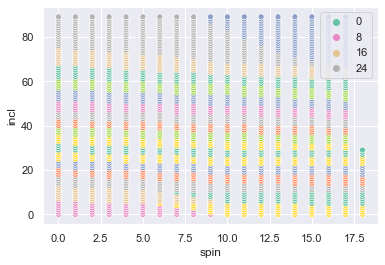

In [11]:
sns.scatterplot(y_data[:,0], y_data[:,1], hue = kmeans.labels_, palette="Set2")
plt.xlabel('spin')
plt.ylabel('incl')

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
y = kmeans.labels_
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# one hot
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
batch_size = 32
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [13]:
ypred = model.predict_classes(X)

Text(0.5, 1.0, 'misclassified points')

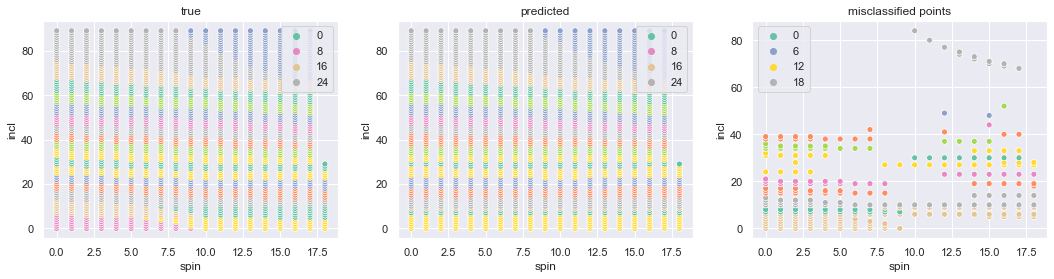

In [14]:
f, ax = plt.subplots(1, 3, figsize=(18,4))

sns.scatterplot(y_data[:,0], y_data[:,1], hue = y, palette="Set2", ax=ax[0])
ax[0].set_xlabel('spin')
ax[0].set_ylabel('incl')
ax[0].set_title('true')

sns.scatterplot(y_data[:,0], y_data[:,1], hue = ypred, palette="Set2", ax=ax[1])
ax[1].set_xlabel('spin')
ax[1].set_ylabel('incl')
ax[1].set_title('predicted')

sns.scatterplot(y_data[y!=ypred,0], y_data[y!=ypred,1], 
                hue = ypred[y!=ypred], palette="Set2", ax=ax[2])
ax[2].set_xlabel('spin')
ax[2].set_ylabel('incl')
ax[2].set_title('misclassified points')

In [ ]:
ypred

In [15]:
# Save the model
model_yaml = model.to_yaml()
with open("kmeans_cnn_incl_spin_20.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("kmeans_cnn_incl_spin_weights_20.h5")
yaml_file.close()

In [ ]:
# Load the model
yaml_file = open('kmeans_cnn_incl_spin.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("kmeans_cnn_incl_spin_weights.h5")

In [ ]:
#make prediction using loaded model
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
ypred = loaded_model.predict_classes(X)

In [ ]:
!pip install lime

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()


In [ ]:
X[0].shape

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
# x = np.append(X[0], X[0], axis=2)
# x = np.append(x, X[0], axis=2)
# np.shape(x)
explanation = explainer.explain_instance(X[0], loaded_model.predict_classes, top_labels=1, hide_color=0, num_samples=1000)

In [ ]:
x = np.append(X[0], X[0], axis=2)
x = np.append(x, X[0], axis=2)
np.shape(x)
x = X[0].reshape(100,100)
print(np.shape(x))
# np.shape(X[0])
# np.shape(X[0])

In [25]:
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data

Skater

In [2]:
import sys, os
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


Using TensorFlow backend.


ModuleNotFoundError: No module named 'skater'

In [5]:
import skater
# import "Skater" related functions
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal, equal_to
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

ModuleNotFoundError: No module named 'skater'